# **PRÁCTICA 1: PREDICCIÓN DE LA PRODUCCIÓN DE ENERGÍA SOLAR**

**Aprendizaje Automatico Curso 2022/2023**

Grupo 10

*   Carmen Abans Maciel - 100432086@alumnos.uc3m.es
*   Noelia Hernandez Rodriguez - 100432116@alumnos.uc3m.es

## Índice


1. Datos
2. Modelo Final

## Datos

In [21]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import statistics
import time

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
import matplotlib.ticker as ticker

# Preprocesado y modelado
# ==============================================================================
from sklearn import metrics
from sklearn import tree
from lineartree import LinearTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from pprint import pprint
import multiprocessing

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_validate, cross_val_score, RepeatedKFold, GridSearchCV, ParameterGrid, PredefinedSplit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.decomposition import PCA
from sklearn.svm import SVR, SVC, LinearSVR
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.utils.fixes import loguniform

from scipy.stats import pearsonr
from scipy.stats import randint as sp_randint

from skopt import BayesSearchCV
from skopt.space import Real
from skopt.plots import plot_convergence, plot_objective

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Leer conjuntos de datos
disp_df = pd.read_csv("disp_st10ns1.txt.bz2", compression="bz2",index_col=0)
comp_df = pd.read_csv("comp_st10ns1.txt.bz2",compression="bz2", index_col=0)

In [23]:
# Listas con los nombres de las variables
disp_feat_names = disp_df.columns[:-1]

In [24]:
# Cambiamos las opciones de respresentación para poder ver todos los valores
pd.options.display.max_columns = 76
pd.options.display.max_rows = 76

In [25]:
# Split de datos
# ================================================================
# Nombrar variable x
x_df = disp_df.drop('salida', axis=1)
X = disp_df.drop('salida', axis=1).to_numpy()
print(type(X)) # Comprobamos que tenemos un array numpy 
print(X.shape) # 4380 instancias y 75 características de entrada
print(X.dtype) # Lo valores son números reales (float64)

# Nombrar variable y
y_df = disp_df['salida']
y = disp_df['salida'].to_numpy()
print(type(y)) # Comprobamos que tenemos un array numpy 
print(y.shape) # 4380 valores de la variable objetivo
print(y.dtype) # Los valores son floats (float64)

# Split de datos
X_train, X_test = np.array_split(X, [3650])
y_train, y_test = np.array_split(y, [3650]) #4380-730 (10 años)

# The indices which have the value -1 will be kept in train. 
train_indices = np.full((2920,), -1, dtype=int) # 8 years

# The indices which have zero or positive values, will be kept in validation
val_indices = np.full((730,), 0, dtype=int) # 2 years 
test_fold = np.append(train_indices, val_indices)

# Creamos PredefinedSplit para hacer validación cruzada
ps = PredefinedSplit(test_fold)

<class 'numpy.ndarray'>
(4380, 75)
float64
<class 'numpy.ndarray'>
(4380,)
int64


In [26]:
# Nombrar variable x para las predicciones
X_comp = comp_df.to_numpy()
print(type(X)) # Comprobamos que tenemos un array numpy 
print(X.shape) # 4380 instancias y 75 características de entrada
print(X.dtype) # Lo valores son números reales (float64)

<class 'numpy.ndarray'>
(4380, 75)
float64


## Funciones

In [27]:
# Cálculo del error cuadrático medio
def rmse(y_test, y_test_pred):
  """ Este es mi cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [28]:
# Para dibujar las predicciones y los valores reales
def pintaResultados (reg, n):
  plt.subplots(figsize=(30, 5))
  x = np.arange(y_test[:n].size)
  pred = reg.predict(X=X_test)
  plt.plot(x, y_test[:n], 'b.', label='Verdaderas')
  plt.plot(x, pred[:n], 'g^', label='Predichas')
  plt.legend()

## Carga del modelo

Hemos elegido ExtremelyRamdomized Tree tras el analisis que se encuentra en el otro archivo.

In [29]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {'n_estimators': sp_randint(10,200),
              'max_features': sp_randint(1,X.shape[1])}

# Hacemos la validación cruzada
budget = 100
rforest_extra = RandomizedSearchCV(ExtraTreesRegressor(), 
                         param_grid,
                         scoring='neg_root_mean_squared_error',
                         refit=True,
                         cv=ps, 
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )

# Reproducibilidad
np.random.seed(10)

# Entrenar el proceso de autoajuste midiendo el tiempo de ejecución
inicio_rforest_extra = time.time()
rforest_extra.fit(X=X_train, y=y_train)
fin_rforest_extra = time.time()

# Predicciones
y_test_pred = rforest_extra.predict(X_test)

# Error
rmse_rforest_extra = -rforest_extra.best_score_
print("RMSE de ExtremelyRandomizedTree ajustado con randomSearch: ", rmse_rforest_extra)

# Tiempo de ejecución
run_time_rforest_extra = fin_rforest_extra-inicio_rforest_extra
print('El metodo de ExtremelyRandomizedTree con randomSearch ha tardado, RMSE:', run_time_rforest_extra, 'segundos')

Fitting 1 folds for each of 100 candidates, totalling 100 fits
RMSE de ExtremelyRandomizedTree ajustado con randomSearch:  2647157.6966109904
El metodo de ExtremelyRandomizedTree con randomSearch ha tardado, RMSE: 66.33695125579834 segundos


In [30]:
# Repetimos la validación cruzada con el MAE en vez de RMSE
# ==============================================================================

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {'n_estimators': sp_randint(10,200),
              'max_features': sp_randint(1,X.shape[1])}

# Hacemos la validación cruzada
budget = 100
rforest_extra = RandomizedSearchCV(ExtraTreesRegressor(), 
                         param_grid,
                         scoring='neg_mean_absolute_error',
                         refit=True,
                         cv=ps, 
                         n_jobs=-1, verbose=1,
                         n_iter=budget
                        )

# Reproducibilidad
np.random.seed(10)

# Entrenar el proceso de autoajuste midiendo el tiempo de ejecución
inicio_rforest_extra = time.time()
rforest_extra.fit(X=X_train, y=y_train)
fin_rforest_extra = time.time()

# Predicciones
y_test_pred = rforest_extra.predict(X_test)

# Error
mae_rforest_extra = -rforest_extra.best_score_
print("MAE de ExtremelyRandomizedTree ajustado con randomSearch: ", mae_rforest_extra)

# Tiempo de ejecución
mae_run_time_rforest_extra = fin_rforest_extra-inicio_rforest_extra
print('El metodo de ExtremelyRandomizedTree con randomSearch ha tardado, MAE:', mae_run_time_rforest_extra, 'segundos')

Fitting 1 folds for each of 100 candidates, totalling 100 fits
MAE de ExtremelyRandomizedTree ajustado con randomSearch:  1862143.2111356605
El metodo de ExtremelyRandomizedTree con randomSearch ha tardado, MAE: 54.43633198738098 segundos


RMSE de RF con búsqueda de hiperparámetros: 2627794.0681900084


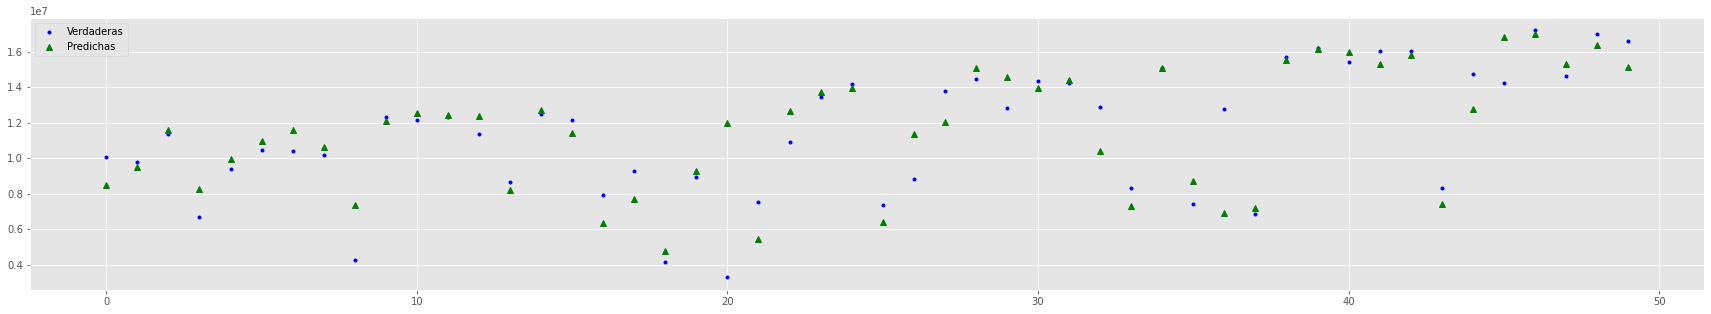

In [31]:
print(f"RMSE de RF con búsqueda de hiperparámetros: {rmse(y_test, rforest_extra.predict(X=X_test))}")
pintaResultados(rforest_extra,50)

In [32]:
rforest_extra.best_params_, -rforest_extra.best_score_

({'max_features': 12, 'n_estimators': 155}, 1862143.2111356605)

In [33]:
# Entrenamos el modelo final
# ==============================================================
modelo_final = rforest_extra.best_estimator_
_ = modelo_final.fit(X_train,y_train)

## Evaluación del modelo

Para evaluar este método vamos a usar la partición de test como estimación de cómo se desempeñaria el modelo en la competición.

In [34]:
# Predecir los valores de y con el conjunto de prueba
y_test_pred = _.predict(X_test)

# Calcular el porcentaje de acierto en la predicción
porcentaje_acierto = r2_score(y_test, y_test_pred)
print("Porcentaje de acierto en la predicción del modelo es de un: {:.2f}%".format(porcentaje_acierto * 100))

Porcentaje de acierto en la predicción del modelo es de un: 88.71%


## Guardar el modelo final en un fichero

In [35]:
# Guardamos el modelo un fichero pkl
pkl_filename = "modelo_final.pkl" 
with open(pkl_filename, 'wb') as file:
    pickle.dump (modelo_final, file)

## Predicciones

In [36]:
y_pred = _.predict(X_comp)

In [37]:
# Guardamos las predicciones en un archivo CSV
np.savetxt("predicciones.csv", y_pred, delimiter=",")